In [1]:
import yfinance as yf
import numpy as np
import pandas as pd
from scipy.signal import argrelextrema
import talib
from abc import ABC, abstractmethod
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [2]:
class FeatureBase(ABC):
    """
    Abstract base class for all features.
    """
    @abstractmethod
    def compute(self, data=None, *args, **kwargs):
        """
        Abstract method to compute the feature value for the given data.
        """
        pass


# TODO: there's some wrong in calculate trend ways, add a new method that can split data by date
class IndicatorTrend(FeatureBase):
    """
    Indicator to calculate the trend based on various methods.
    """
    def compute(self, data, *args, **kwargs):
        """
        Compute the trend for the given data using the specified method.

        Parameters:
        - data: DataFrame containing the data.
        - method: Method for trend calculation (e.g., 'MA', 'LocalExtrema').
        - ma_days: Number of days for moving average.
        - oder_days: Number of days for order.
        - trend_days: Number of days to determine the trend.

        Returns:
        - DataFrame with trend values.
        """
        method = kwargs.get('method', 'MA')
        ma_days = kwargs.get('ma_days', 20)
        oder_days = kwargs.get('oder_days', 20)
        trend_days = kwargs.get('trend_days', 5)

        if method == 'MA':
            return self.calculate_trend_MA(data, ma_days=ma_days, trend_days=trend_days)
        elif method == 'LocalExtrema':
            return self.calculate_trend_LocalExtrema(data, oder_days=oder_days)
        else:
            raise ValueError(f"Invalid trend calculation method: {method}")

    def calculate_trend_MA(self, data, ma_days=20, trend_days=5):
        """
        Calculate trend using Moving Average method.

        Parameters:
        - data: DataFrame containing the data.
        - ma_days: Number of days for moving average.
        - trend_days: Number of days to determine the trend.

        Returns:
        - DataFrame with trend values.
        """
        data['MA'] = data['Close'].rolling(window=ma_days).mean()
        data['Trend'] = np.nan
        n = len(data)

        for i in range(n - trend_days + 1):
            if all(data['MA'].iloc[i + j] < data['MA'].iloc[i + j + 1] for j in range(trend_days - 1)):
                data['Trend'].iloc[i:i + trend_days] = 0
            elif all(data['MA'].iloc[i + j] > data['MA'].iloc[i + j + 1] for j in range(trend_days - 1)):
                data['Trend'].iloc[i:i + trend_days] = 1
        data['Trend'].fillna(method='ffill', inplace=True)
        return data.drop(columns=['MA'])

    def calculate_trend_LocalExtrema(self, data, oder_days=20):
        """
        Calculate trend using Local Extrema method.

        Parameters:
        - data: DataFrame containing the data.
        - oder_days: Number of days for order.

        Returns:
        - DataFrame with trend values.
        """
        local_max_indices = argrelextrema(
            data['Close'].values, np.greater_equal, order=oder_days)[0]
        local_min_indices = argrelextrema(
            data['Close'].values, np.less_equal, order=oder_days)[0]
        data['Local Max'] = data.iloc[local_max_indices]['Close']
        data['Local Min'] = data.iloc[local_min_indices]['Close']
        data['Trend'] = np.nan
        prev_idx = None
        prev_trend = None
        prev_type = None

        for idx in sorted(np.concatenate([local_max_indices, local_min_indices])):
            if idx in local_max_indices:
                current_type = "max"
            else:
                current_type = "min"

            if prev_trend is None:
                if current_type == "max":
                    prev_trend = 1
                else:
                    prev_trend = 0
            else:
                if prev_type == "max" and current_type == "min":
                    data.loc[prev_idx:idx, 'Trend'] = 1
                    prev_trend = 1
                elif prev_type == "min" and current_type == "max":
                    data.loc[prev_idx:idx, 'Trend'] = 0
                    prev_trend = 0
                else:
                    if current_type == "max":
                        data.loc[prev_idx:idx, 'Trend'] = 0
                        prev_trend = 0
                    else:
                        data.loc[prev_idx:idx, 'Trend'] = 1
                        prev_trend = 1

            prev_idx = idx
            prev_type = current_type
        data['Trend'].fillna(method='ffill', inplace=True)
        return data.drop(columns=['Local Max', 'Local Min'])


class IndicatorMACD(FeatureBase):
    """
    Indicator to calculate the Moving Average Convergence Divergence (MACD).
    """

    def compute(self, data, *args, **kwargs):
        fastperiod = kwargs.get('fastperiod', 5)
        slowperiod = kwargs.get('slowperiod', 10)
        signalperiod = kwargs.get('signalperiod', 9)
        data['MACD'], _, _ = talib.MACD(
            data['Close'], fastperiod=fastperiod, slowperiod=slowperiod, signalperiod=signalperiod)
        return data


class IndicatorROC(FeatureBase):
    def compute(self, data, *args, **kwargs):
        trend_days = kwargs.get('trend_days', 5)
        data['ROC'] = talib.ROC(data['Close'], timeperiod=trend_days)
        return data


class IndicatorStochasticOscillator(FeatureBase):
    def compute(self, data, *args, **kwargs):
        trend_days = kwargs.get('trend_days', 5)
        data['StoK'], data['StoD'] = talib.STOCH(
            data['High'], data['Low'], data['Close'], fastk_period=trend_days, slowk_period=3, slowd_period=3)
        return data


class IndicatorCCI(FeatureBase):
    def compute(self, data, *args, **kwargs):
        timeperiod = kwargs.get('timeperiod', 14)
        data['CCI'] = talib.CCI(data['High'], data['Low'],
                                data['Close'], timeperiod=timeperiod)
        return data


class IndicatorRSI(FeatureBase):
    def compute(self, data, *args, **kwargs):
        timeperiod = kwargs.get('timeperiod', 14)
        data['RSI'] = talib.RSI(data['Close'], timeperiod=timeperiod)
        return data


class IndicatorVMA(FeatureBase):
    def compute(self, data, *args, **kwargs):
        timeperiod = kwargs.get('timeperiod', 20)
        data['VMA'] = talib.MA(data['Volume'], timeperiod=timeperiod)
        return data


class IndicatorPctChange(FeatureBase):
    def compute(self, data, *args, **kwargs):
        data['pctChange'] = data['Close'].pct_change() * 100
        return data


class TreasuryYieldThreeMonth(FeatureBase):
    def compute(self, data, *args, **kwargs):
        start_date = kwargs.get('start_date')
        end_date = kwargs.get('end_date')
        three_month_treasury_yield = yf.download(
            "^IRX", start_date, end_date)["Close"]
        data['3M Treasury Yield'] = three_month_treasury_yield
        return data


class TreasuryYieldFiveYear(FeatureBase):
    def compute(self, data, *args, **kwargs):
        start_date = kwargs.get('start_date')
        end_date = kwargs.get('end_date')
        five_year_treasury_yield = yf.download(
            "^FVX", start_date, end_date)["Close"]
        data['5Y Treasury Yield'] = five_year_treasury_yield
        return data


class TreasuryYieldTenYear(FeatureBase):
    def compute(self, data, *args, **kwargs):
        start_date = kwargs.get('start_date')
        end_date = kwargs.get('end_date')
        ten_year_treasury_yield = yf.download(
            "^TNX", start_date, end_date)["Close"]
        data['10Y Treasury Yield'] = ten_year_treasury_yield
        return data


class TreasuryYieldThirtyYear(FeatureBase):
    def compute(self, data, *args, **kwargs):
        start_date = kwargs.get('start_date')
        end_date = kwargs.get('end_date')
        thirty_year_treasury_yield = yf.download(
            "^TYX", start_date, end_date)["Close"]
        data['30Y Treasury Yield'] = thirty_year_treasury_yield
        return data
# Add other features here as needed


class FeatureFactory:
    """
    Factory class dedicated to creating various technical features.
    """
    @staticmethod
    def get_feature(feature_type):
        """
        Retrieve the desired feature based on the specified type.

        Parameters:
        - feature_type: Type of feature (e.g., 'Trend', 'MACD').

        Returns:
        - Feaature object corresponding to the specified type.

        Raises:
        - ValueError: If the provided feature type is not supported.
        """
        features = {
            "Trend": IndicatorTrend,
            "MACD": IndicatorMACD,
            "ROC": IndicatorROC,
            "Stochastic Oscillator": IndicatorStochasticOscillator,
            "CCI": IndicatorCCI,
            "RSI": IndicatorRSI,
            "VMA": IndicatorVMA,
            "PctChange": IndicatorPctChange,
            "3M Treasury Yield": TreasuryYieldThreeMonth,
            "5Y Treasury Yield": TreasuryYieldFiveYear,
            "10Y Treasury Yield": TreasuryYieldTenYear,
            "30Y Treasury Yield": TreasuryYieldThirtyYear,
            # Add other features here as needed
        }
        feature = features.get(feature_type)
        if feature is None:
            raise ValueError(f"Invalid feature type: {feature_type}")
        return feature()


class CleanerBase(ABC):
    """Abstract base class for data processors."""
    @abstractmethod
    def check(self, data):
        """Method to check the data for issues."""
        pass

    @abstractmethod
    def clean(self, data):
        """Method to clean the data from identified issues."""
        pass


class CleanerMissingValue(CleanerBase):
    """Concrete class for checking and handling missing data."""
    def check(self, data):
        """Check for missing data in the dataframe."""
        return data.isnull().sum()

    def clean(self, data, strategy='auto'):
        """Handle missing data based on the chosen strategy."""
        if strategy == 'auto':
            while data.iloc[0].isnull().any():
                data = data.iloc[1:]
            data.fillna(method='ffill', inplace=True)

        elif strategy == 'drop':
            data.dropna(inplace=True)

        elif strategy == 'fillna':
            data.fillna(method='ffill', inplace=True)

        elif strategy == 'none':
            pass

        else:
            raise ValueError("Invalid strategy provided.")

        return data


class ProcessorFactory:
    """Factory class to creat data processors."""
    @staticmethod
    def get_cleaner(clean_type, *args, **kwargs):
        """creat a data processor based on the provided type."""
        if clean_type == "MissingData":
            return CleanerMissingValue(*args, **kwargs)
        else:
            raise ValueError(f"Processor type {clean_type} not recognized.")

    @staticmethod
    def get_standardize_method(data, method='StandardScaler'):
        """Standardize the data using the specified method."""
        if method == 'StandardScaler':
            scaler = StandardScaler()
        elif method == 'MinMaxScaler':
            scaler = MinMaxScaler()
        else:
            raise ValueError(f"Invalid scaler method: {method}.")
        return scaler.fit_transform(data)

    @staticmethod
    def standardize_and_split_data(data, split_ratio=0.7, target_col="Trend", feature_cols=None):
        """Standardize the data and split it into training and testing sets."""
        if not feature_cols:
            feature_cols = data.columns.to_list()
        x_data = data[feature_cols]

        # Generate the one-hot encoding
        y_data = pd.get_dummies(data[target_col], prefix='Trend')

        # Check if the split index is valid
        split_idx = int(len(x_data) * split_ratio)
        if split_idx < 1 or split_idx >= len(x_data):
            raise ValueError(
                "Invalid split ratio leading to incorrect data partitioning.")

        X_test = x_data.iloc[split_idx:]
        y_test = y_data.iloc[split_idx:]
        X_train = x_data.iloc[:split_idx]
        y_train = y_data.iloc[:split_idx]

        return X_train, y_train, X_test, y_test

    @staticmethod
    def prepare_multistep_data(x_data, y_data, look_back, predict_steps, slide_steps=1):
        """
        Prepare the data for multi-step prediction and apply standardization within each sliding window.
        """
        x_date = []
        y_date = []
        x_data_multistep = []
        y_data_multistep = []

        for i in range(0, len(x_data) - look_back - predict_steps + 1, slide_steps):
            x_date.append(x_data.index[i:i + look_back])

            y_date.append(
                x_data.index[i + look_back:i + look_back + predict_steps])

            x_window = x_data.iloc[i:i + look_back].values
            y_window = y_data.iloc[i + look_back:i +
                                   look_back + predict_steps].values

            x_window_standardized = ProcessorFactory.get_standardize_method(
                x_window)

            x_data_multistep.append(x_window_standardized)
            y_data_multistep.append(y_window)

        return np.array(x_data_multistep), np.array(y_data_multistep), np.array(x_date), np.array(y_date)


class Preprocessor:
    """
    Fetching, processing, and preparing model data.
    """
    def __init__(self, data=None, start_date=None, end_date=None):
        # self.data = data
        self.start_date = start_date
        self.end_date = end_date
        self.trend_method = "MA"
        self.features = []
        self.processors = []

    def set_seed(self, seed_value=42):
        """Set seed for reproducibility."""
        np.random.seed(seed_value)

    def fetch_stock_data(self, stock_symbol, start_date=None, end_date=None):
        """Fetch stock data from Yahoo Finance."""
        if start_date:
            self.start_date = start_date
        if end_date:
            self.end_date = end_date
        return yf.download(stock_symbol, start=self.start_date, end=self.end_date)

    def add_feature(self, feature_type, *args, **kwargs):
        feature = FeatureFactory.get_feature(feature_type)
        self.data = feature.compute(self.data, *args, **kwargs)

    def add_data_cleaner(self, clean_type='MissingData', strategy='drop'):
        """Method to check and clean the data using a specific processor."""
        processor = ProcessorFactory.get_cleaner(clean_type)
        issues = processor.check(self.data)
        self.data = processor.clean(self.data, strategy=strategy)
        return issues

    def process_data(self, split_ratio=0.7, target_col="Trend", feature_cols=None, look_back=64, predict_steps=16, train_slide_steps=1, test_slide_steps=16):
        """
        Use ProcessorFactory to standardize and split the data, and prepare it for multi-step prediction if required.
        """
        X_train, y_train, X_test, y_test = ProcessorFactory.standardize_and_split_data(
            self.data, split_ratio, target_col, feature_cols)

        if look_back and predict_steps:
            X_train, y_train, train_dates, _ = ProcessorFactory.prepare_multistep_data(
                X_train, y_train, look_back, predict_steps, train_slide_steps)
            X_test, y_test, _, test_dates = ProcessorFactory.prepare_multistep_data(
                X_test, y_test, look_back, predict_steps, test_slide_steps)
            return X_train, y_train, X_test, y_test, train_dates, test_dates
        else:
            raise ValueError("Invalid look_back or predict_steps provided for data preparation.")

model_data = Preprocessor()
model_data.set_seed(42)
start_date = "2001-01-01"
stop_date = "2021-01-01"
stock_symbol = "^GSPC"
model_data.data = model_data.fetch_stock_data(
    stock_symbol, start_date, stop_date)

[*********************100%***********************]  1 of 1 completed


In [3]:
features = [
    {"type": "Trend", "method": "MA", "oder_days": 20,
        "ma_days": 20, "trend_days": 5},
    {"type": "MACD", "fastperiod": 5, "slowperiod": 10, "signalperiod": 9},
    {"type": "ROC", "trend_days": 5},
    {"type": "Stochastic Oscillator", "trend_days": 5},
    {"type": "CCI", "timeperiod": 14},
    {"type": "RSI", "timeperiod": 14},
    {"type": "VMA", "timeperiod": 20},
    {"type": "PctChange"},
    {"type": "3M Treasury Yield", "start_date": "2001-01-01", "end_date": "2021-01-01"},
    {"type": "5Y Treasury Yield", "start_date": "2001-01-01", "end_date": "2021-01-01"},
    {"type": "10Y Treasury Yield", "start_date": "2001-01-01", "end_date": "2021-01-01"},
    {"type": "30Y Treasury Yield", "start_date": "2001-01-01", "end_date": "2021-01-01"},
]  # Add other features here as needed

for feature_params in features:
    feature_type = feature_params["type"]
    model_data.add_feature(feature_type, **feature_params)

C:\Users\e4903\AppData\Local\Temp\ipykernel_5292\1196187592.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Trend'].iloc[i:i + trend_days] = 0
C:\Users\e4903\AppData\Local\Temp\ipykernel_5292\1196187592.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Trend'].iloc[i:i + trend_days] = 1


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [4]:
issues_detected = model_data.add_data_cleaner("MissingData", strategy='auto')


In [5]:
split_ratio = 0.7
target_col = "Trend"
# feature_cols = None  # None means use all columns
feature_cols = ['Trend']
look_back = 64  # number of previous days' data to consider
predict_steps = 16  # number of days to predict in the future
slide_steps = 1  # sliding window step size

X_train, y_train, X_test, y_test, train_dates, test_dates = model_data.process_data(split_ratio=0.7, target_col="Trend", feature_cols=feature_cols, look_back=look_back,
                        predict_steps=predict_steps, train_slide_steps=1, test_slide_steps=predict_steps)

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((3430, 64, 1), (3430, 16, 2), (90, 64, 1), (90, 16, 2))

In [6]:
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, LSTM, Conv1D, MaxPooling1D, Flatten, Reshape
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import yfinance as yf
from scipy.signal import argrelextrema

In [7]:
import numpy as np
import tensorflow as tf
import random

def set_seed(seed_value):
    np.random.seed(seed_value)
    tf.random.set_seed(seed_value)
    random.seed(seed_value)
set_seed(42)

In [8]:
from kerastuner import RandomSearch
from keras.models import Sequential
from keras.layers import LSTM, Dense, RepeatVector, TimeDistributed, Conv1D, MaxPooling1D, Dropout, BatchNormalization, Activation
from keras.optimizers import Adam
from keras import regularizers
from keras import metrics

params = {
        'conv_1_filter': 32,
        'conv_1_kernel': 4,
        'conv_1_l2': 0.00016475815766673417,
        'dropout_1': 0.2,
        'conv_2_filter': 96,
        'conv_2_kernel': 2,
        'dropout_2': 0.2,
        'lstm_1_units': 128,
        'lstm_1_l2': 0.0002788818914602332,
        'dropout_3': 0.2,
        'lstm_2_units': 64,
        'dropout_4': 0.1,
        'learning_rate': 0.001
    }

def build_model():
    # Parameters from the provided dictionary

    model = Sequential()
    
    # Encoder
    model.add(Conv1D(filters=params['conv_1_filter'],
                     kernel_size=params['conv_1_kernel'],
                     activation=None,
                     padding='same',
                     kernel_regularizer=regularizers.l2(params['conv_1_l2']),
                     input_shape=(look_back, X_train.shape[-1])))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(params['dropout_1']))
    model.add(MaxPooling1D(pool_size=2))
    
    model.add(Conv1D(filters=params['conv_2_filter'],
                     kernel_size=params['conv_2_kernel'],
                     activation=None))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(params['dropout_2']))
    model.add(MaxPooling1D(pool_size=2))
    
    model.add(LSTM(units=params['lstm_1_units'],
                   activation=None,
                   return_sequences=False,
                   kernel_regularizer=regularizers.l2(params['lstm_1_l2'])))
    model.add(BatchNormalization())
    model.add(Activation('tanh'))
    model.add(Dropout(params['dropout_3']))
    
    # Set the desired output sequence length using RepeatVector
    model.add(RepeatVector(predict_steps))
    
    # Decoder
    model.add(LSTM(units=params['lstm_2_units'],
                   activation=None,
                   return_sequences=True))
    model.add(BatchNormalization())
    model.add(Activation('tanh'))
    model.add(Dropout(params['dropout_4']))
    model.add(TimeDistributed(Dense(2, activation='softmax')))
    
    optimizer = Adam(learning_rate=params['learning_rate'])
    model.compile(optimizer=optimizer,
                  loss='binary_crossentropy',
                  metrics=[metrics.BinaryAccuracy()])
    model.summary()
    
    return model


C:\Users\e4903\AppData\Local\Temp\ipykernel_5292\28269160.py:1: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner import RandomSearch


In [9]:
# TODO: 這種方法無法使用Model原來的api，考慮其他方法
# TODO: 重寫evaluation，邏輯有問題

In [10]:
class ModelFactory:
    def __init__(self):
        self._models = {
            'seq2seq': self._build_seq2seq_model,
            'cnn': self._build_cnn_model
            # Additional models can be added here
        }

    def build_model(self, model_type, params, input_shape):
        if model_type not in self._models:
            raise ValueError(f"Model type {model_type} not recognized.")
        return self._models[model_type](params, input_shape)

    def _build_seq2seq_model(self, params, input_shape):
        model = Sequential()
        # Encoder
        model.add(Conv1D(filters=params['conv_1_filter'],
                        kernel_size=params['conv_1_kernel'],
                        activation=None,
                        padding='same',
                        kernel_regularizer=regularizers.l2(params['conv_1_l2']),
                        input_shape=input_shape))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(Dropout(params['dropout_1']))
        model.add(MaxPooling1D(pool_size=2))
        
        model.add(Conv1D(filters=params['conv_2_filter'],
                        kernel_size=params['conv_2_kernel'],
                        activation=None))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(Dropout(params['dropout_2']))
        model.add(MaxPooling1D(pool_size=2))
        
        model.add(LSTM(units=params['lstm_1_units'],
                    activation=None,
                    return_sequences=False,
                    kernel_regularizer=regularizers.l2(params['lstm_1_l2'])))
        model.add(BatchNormalization())
        model.add(Activation('tanh'))
        model.add(Dropout(params['dropout_3']))
        
        # Set the desired output sequence length using RepeatVector
        model.add(RepeatVector(predict_steps))
        
        # Decoder
        model.add(LSTM(units=params['lstm_2_units'],
                    activation=None,
                    return_sequences=True))
        model.add(BatchNormalization())
        model.add(Activation('tanh'))
        model.add(Dropout(params['dropout_4']))
        model.add(TimeDistributed(Dense(2, activation='softmax')))
        
        optimizer = Adam(learning_rate=params['learning_rate'])
        model.compile(optimizer=optimizer,
                    loss='binary_crossentropy',
                    metrics=[metrics.BinaryAccuracy()])
        model.summary()
        
        return model


    def _build_cnn_model(self, params, input_shape):
        # CNN model creation logic
        pass

# Usage example
factory = ModelFactory()
input_shape = (look_back, X_train.shape[-1])
params = {
        'conv_1_filter': 32,
        'conv_1_kernel': 4,
        'conv_1_l2': 0.00016475815766673417,
        'dropout_1': 0.2,
        'conv_2_filter': 96,
        'conv_2_kernel': 2,
        'dropout_2': 0.2,
        'lstm_1_units': 128,
        'lstm_1_l2': 0.0002788818914602332,
        'dropout_3': 0.2,
        'lstm_2_units': 64,
        'dropout_4': 0.1,
        'learning_rate': 0.001
    }
seq2seq_model = factory.build_model('seq2seq', params, input_shape)
cnn_model = factory.build_model('cnn', params, input_shape)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 64, 32)            160       
                                                                 
 batch_normalization (BatchN  (None, 64, 32)           128       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 64, 32)            0         
                                                                 
 dropout (Dropout)           (None, 64, 32)            0         
                                                                 
 max_pooling1d (MaxPooling1D  (None, 32, 32)           0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 31, 96)            6

In [11]:
from keras.callbacks import EarlyStopping

class Trainer:
    def __init__(self, model, params):
        self.model = model
        self.params = params

    def train(self, X_train, y_train, X_test, y_test):
        # Define callbacks, such as EarlyStopping
        early_stopping = EarlyStopping(
            monitor='loss', 
            patience=self.params.get('patience', 5), 
            restore_best_weights=True
        )

        # Train the model
        history = self.model.fit(
            X_train, y_train,
            epochs=self.params.get('epochs', 10),
            batch_size=self.params.get('batch_size', 32),
            # validation_data=(X_test, y_test),
            # callbacks=[early_stopping],
            verbose=2
        )

        return history

    def evaluate(self, X_test, y_test):
        # Evaluate the model on the validation set
        evaluation = self.model.evaluate(X_test, y_test, verbose=0)
        return evaluation

# Usage example
params = {
    'epochs': 10,
    'batch_size': 64,
    'patience': 5  # You can add more parameters as needed
}
trainer = Trainer(seq2seq_model, params)
history = trainer.train(X_train, y_train, X_test, y_test)

# After training, evaluate the model
evaluation = trainer.evaluate(X_test, y_test)

# You can print or log the evaluation metrics
print(f"Validation Loss: {evaluation[0]}")
print(f"Validation Accuracy: {evaluation[1]}")


Epoch 1/10
54/54 - 22s - loss: 0.6154 - binary_accuracy: 0.7307 - 22s/epoch - 406ms/step
Epoch 2/10
54/54 - 4s - loss: 0.5530 - binary_accuracy: 0.7700 - 4s/epoch - 83ms/step
Epoch 3/10
54/54 - 4s - loss: 0.5465 - binary_accuracy: 0.7700 - 4s/epoch - 81ms/step
Epoch 4/10
54/54 - 5s - loss: 0.5293 - binary_accuracy: 0.7781 - 5s/epoch - 87ms/step
Epoch 5/10
54/54 - 5s - loss: 0.5120 - binary_accuracy: 0.7895 - 5s/epoch - 88ms/step
Epoch 6/10
54/54 - 5s - loss: 0.5051 - binary_accuracy: 0.7888 - 5s/epoch - 87ms/step
Epoch 7/10
54/54 - 5s - loss: 0.4965 - binary_accuracy: 0.7923 - 5s/epoch - 87ms/step
Epoch 8/10
54/54 - 5s - loss: 0.4890 - binary_accuracy: 0.7968 - 5s/epoch - 96ms/step
Epoch 9/10
54/54 - 5s - loss: 0.4828 - binary_accuracy: 0.7982 - 5s/epoch - 98ms/step
Epoch 10/10
54/54 - 5s - loss: 0.4689 - binary_accuracy: 0.8017 - 5s/epoch - 91ms/step
Validation Loss: 0.5786374807357788
Validation Accuracy: 0.769444465637207


In [12]:
from tqdm import tqdm
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score

class OnlineTrainer:
    def __init__(self, model):
        self.model = model

    def online_train(self, X_train, y_train, X_test, y_test):
        training_losses = []
        training_acc = []
        val_losses = []
        val_acc = []
        y_preds = []
        for i in tqdm(range(len(X_test))):
            # Predict the next instance (optional, depending on your requirements)
            y_pred = self.model.predict(X_test[i:i+1])
            y_preds.append(y_pred[0])
            # Add the instance and its actual result to the training dataset
            X_train = np.append(X_train, X_test[i:i+1], axis=0)
            y_train = np.append(y_train, y_test[i:i+1], axis=0)

            # Retrain the model on this updated dataset
            history = self.model.fit(
                X_test[i:i+1], y_test[i:i+1],
                epochs=1, verbose=2
            )
            # training_losses.append(history.history['loss'][0])
            # training_acc.append(history.history['binary_accuracy'][0])
            # val_losses.append(history.history['val_loss'][0])
            # val_acc.append(history.history['val_binary_accuracy'][0])
        y_preds = np.array(y_preds)
        # Return training and validation metrics
        return y_preds, training_losses, training_acc, val_losses, val_acc

    def evaluate(self, y_preds, y_test):
        # Flatten the 3D tensors for evaluation
        y_test_flat = np.argmax(y_test.reshape(-1, y_test.shape[-1]), axis=1)
        y_preds_flat = np.argmax(y_preds.reshape(-1, y_preds.shape[-1]), axis=1)

        # Calculate evaluation metrics
        precision = precision_score(y_test_flat, y_preds_flat, average='macro')
        recall = recall_score(y_test_flat, y_preds_flat, average='macro')
        accuracy = accuracy_score(y_test_flat, y_preds_flat)
        f1 = f1_score(y_test_flat, y_preds_flat, average='macro')

        return precision, recall, accuracy, f1

# Usage example
online_trainer = OnlineTrainer(seq2seq_model)
y_preds, training_losses, training_acc, val_losses, val_acc = online_trainer.online_train(X_train, y_train, X_test, y_test)
precision, recall, accuracy, f1 = online_trainer.evaluate(y_preds, y_test)

# Output the evaluation metrics
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'Accuracy: {accuracy}')
print(f'F1 Score: {f1}')

  0%|          | 0/90 [00:00<?, ?it/s]

1/1 [==============================] - 2s 2s/step
1/1 - 0s - loss: 0.5968 - binary_accuracy: 0.6875 - 35ms/epoch - 35ms/step


  1%|          | 1/90 [00:02<04:18,  2.91s/it]

1/1 [==============================] - 0s 110ms/step
1/1 - 0s - loss: 0.6138 - binary_accuracy: 0.6875 - 32ms/epoch - 32ms/step


  2%|▏         | 2/90 [00:03<02:13,  1.52s/it]

1/1 [==============================] - 0s 70ms/step
1/1 - 0s - loss: 0.8376 - binary_accuracy: 0.2500 - 23ms/epoch - 23ms/step


  3%|▎         | 3/90 [00:03<01:26,  1.00it/s]

1/1 [==============================] - 0s 111ms/step
1/1 - 0s - loss: 0.8061 - binary_accuracy: 0.3125 - 32ms/epoch - 32ms/step


  4%|▍         | 4/90 [00:04<01:11,  1.21it/s]

1/1 [==============================] - 0s 112ms/step
1/1 - 0s - loss: 0.7303 - binary_accuracy: 0.6250 - 40ms/epoch - 40ms/step


  6%|▌         | 5/90 [00:05<01:05,  1.30it/s]

1/1 [==============================] - 0s 106ms/step
1/1 - 0s - loss: 0.9266 - binary_accuracy: 0.0000e+00 - 21ms/epoch - 21ms/step


  7%|▋         | 6/90 [00:05<00:57,  1.45it/s]

1/1 [==============================] - 0s 61ms/step
1/1 - 0s - loss: 0.8970 - binary_accuracy: 0.1875 - 32ms/epoch - 32ms/step


  8%|▊         | 7/90 [00:05<00:48,  1.71it/s]

1/1 [==============================] - 0s 109ms/step
1/1 - 0s - loss: 0.6321 - binary_accuracy: 0.6875 - 30ms/epoch - 30ms/step


  9%|▉         | 8/90 [00:06<00:48,  1.70it/s]

1/1 [==============================] - 0s 83ms/step
1/1 - 0s - loss: 0.5983 - binary_accuracy: 0.6875 - 28ms/epoch - 28ms/step


 10%|█         | 9/90 [00:07<00:47,  1.69it/s]

1/1 [==============================] - 0s 118ms/step
1/1 - 0s - loss: 0.7778 - binary_accuracy: 0.5625 - 30ms/epoch - 30ms/step


 11%|█         | 10/90 [00:07<00:50,  1.60it/s]

1/1 [==============================] - 0s 132ms/step
1/1 - 0s - loss: 0.9775 - binary_accuracy: 0.3750 - 33ms/epoch - 33ms/step


 12%|█▏        | 11/90 [00:08<00:51,  1.52it/s]

1/1 [==============================] - 0s 196ms/step
1/1 - 0s - loss: 0.9914 - binary_accuracy: 0.3125 - 42ms/epoch - 42ms/step


 13%|█▎        | 12/90 [00:09<00:52,  1.48it/s]

1/1 [==============================] - 0s 75ms/step
1/1 - 0s - loss: 0.9327 - binary_accuracy: 0.3750 - 44ms/epoch - 44ms/step


 14%|█▍        | 13/90 [00:09<00:51,  1.48it/s]

1/1 [==============================] - 0s 137ms/step
1/1 - 0s - loss: 0.5746 - binary_accuracy: 0.8750 - 47ms/epoch - 47ms/step


 16%|█▌        | 14/90 [00:10<00:53,  1.42it/s]

1/1 [==============================] - 0s 119ms/step
1/1 - 0s - loss: 0.5871 - binary_accuracy: 0.8750 - 22ms/epoch - 22ms/step


 17%|█▋        | 15/90 [00:11<00:51,  1.46it/s]

1/1 [==============================] - 0s 68ms/step
1/1 - 0s - loss: 0.6262 - binary_accuracy: 0.9375 - 31ms/epoch - 31ms/step


 18%|█▊        | 16/90 [00:11<00:47,  1.57it/s]

1/1 [==============================] - 0s 156ms/step
1/1 - 0s - loss: 0.6378 - binary_accuracy: 0.8125 - 39ms/epoch - 39ms/step


 19%|█▉        | 17/90 [00:12<00:49,  1.47it/s]

1/1 [==============================] - 0s 201ms/step
1/1 - 0s - loss: 0.9112 - binary_accuracy: 0.1875 - 39ms/epoch - 39ms/step


 20%|██        | 18/90 [00:13<00:52,  1.37it/s]

1/1 [==============================] - 0s 156ms/step
1/1 - 0s - loss: 0.5897 - binary_accuracy: 0.9375 - 30ms/epoch - 30ms/step


 21%|██        | 19/90 [00:14<00:51,  1.38it/s]

1/1 [==============================] - 0s 140ms/step
1/1 - 0s - loss: 0.7193 - binary_accuracy: 0.6250 - 31ms/epoch - 31ms/step


 22%|██▏       | 20/90 [00:15<00:51,  1.36it/s]

1/1 [==============================] - 0s 107ms/step
1/1 - 0s - loss: 0.6121 - binary_accuracy: 0.8750 - 20ms/epoch - 20ms/step


 23%|██▎       | 21/90 [00:15<00:46,  1.48it/s]

1/1 [==============================] - 0s 134ms/step
1/1 - 0s - loss: 0.6259 - binary_accuracy: 0.8125 - 27ms/epoch - 27ms/step


 24%|██▍       | 22/90 [00:16<00:46,  1.47it/s]

1/1 [==============================] - 0s 217ms/step
1/1 - 0s - loss: 0.8966 - binary_accuracy: 0.2500 - 38ms/epoch - 38ms/step


 26%|██▌       | 23/90 [00:17<00:51,  1.31it/s]

1/1 [==============================] - 0s 60ms/step
1/1 - 0s - loss: 0.7915 - binary_accuracy: 0.3750 - 20ms/epoch - 20ms/step


 27%|██▋       | 24/90 [00:17<00:43,  1.51it/s]

1/1 [==============================] - 0s 120ms/step
1/1 - 0s - loss: 0.8088 - binary_accuracy: 0.3750 - 40ms/epoch - 40ms/step


 28%|██▊       | 25/90 [00:18<00:42,  1.52it/s]

1/1 [==============================] - 0s 122ms/step
1/1 - 0s - loss: 0.5625 - binary_accuracy: 0.9375 - 30ms/epoch - 30ms/step


 29%|██▉       | 26/90 [00:18<00:41,  1.53it/s]

1/1 [==============================] - 0s 110ms/step
1/1 - 0s - loss: 0.5829 - binary_accuracy: 0.8125 - 21ms/epoch - 21ms/step


 30%|███       | 27/90 [00:19<00:39,  1.58it/s]

1/1 [==============================] - 0s 129ms/step
1/1 - 0s - loss: 0.5277 - binary_accuracy: 0.8125 - 39ms/epoch - 39ms/step


 31%|███       | 28/90 [00:20<00:40,  1.53it/s]

1/1 [==============================] - 0s 66ms/step
1/1 - 0s - loss: 0.5615 - binary_accuracy: 0.7500 - 30ms/epoch - 30ms/step


 32%|███▏      | 29/90 [00:20<00:39,  1.56it/s]

1/1 [==============================] - 0s 66ms/step
1/1 - 0s - loss: 0.5474 - binary_accuracy: 0.8750 - 21ms/epoch - 21ms/step


 33%|███▎      | 30/90 [00:21<00:33,  1.78it/s]

1/1 [==============================] - 0s 130ms/step
1/1 - 0s - loss: 1.0491 - binary_accuracy: 0.1250 - 33ms/epoch - 33ms/step


 34%|███▍      | 31/90 [00:21<00:33,  1.74it/s]

1/1 [==============================] - 0s 119ms/step
1/1 - 0s - loss: 0.7392 - binary_accuracy: 0.5000 - 29ms/epoch - 29ms/step


 36%|███▌      | 32/90 [00:22<00:34,  1.69it/s]

1/1 [==============================] - 0s 124ms/step
1/1 - 0s - loss: 0.5212 - binary_accuracy: 1.0000 - 19ms/epoch - 19ms/step


 37%|███▋      | 33/90 [00:22<00:33,  1.72it/s]

1/1 [==============================] - 0s 59ms/step
1/1 - 0s - loss: 0.5546 - binary_accuracy: 0.8750 - 30ms/epoch - 30ms/step


 38%|███▊      | 34/90 [00:23<00:29,  1.92it/s]

1/1 [==============================] - 0s 112ms/step
1/1 - 0s - loss: 0.5538 - binary_accuracy: 0.9375 - 30ms/epoch - 30ms/step


 39%|███▉      | 35/90 [00:23<00:29,  1.86it/s]

1/1 [==============================] - 0s 150ms/step
1/1 - 0s - loss: 0.6100 - binary_accuracy: 0.8125 - 23ms/epoch - 23ms/step


 40%|████      | 36/90 [00:24<00:30,  1.80it/s]

1/1 [==============================] - 0s 110ms/step
1/1 - 0s - loss: 0.6253 - binary_accuracy: 0.7500 - 27ms/epoch - 27ms/step


 41%|████      | 37/90 [00:25<00:29,  1.77it/s]

1/1 [==============================] - 0s 121ms/step
1/1 - 0s - loss: 0.8927 - binary_accuracy: 0.2500 - 25ms/epoch - 25ms/step


 42%|████▏     | 38/90 [00:25<00:31,  1.66it/s]

1/1 [==============================] - 0s 120ms/step
1/1 - 0s - loss: 0.5097 - binary_accuracy: 0.9375 - 20ms/epoch - 20ms/step


 43%|████▎     | 39/90 [00:26<00:30,  1.68it/s]

1/1 [==============================] - 0s 57ms/step
1/1 - 0s - loss: 0.5457 - binary_accuracy: 1.0000 - 31ms/epoch - 31ms/step


 44%|████▍     | 40/90 [00:26<00:26,  1.91it/s]

1/1 [==============================] - 0s 91ms/step
1/1 - 0s - loss: 0.5112 - binary_accuracy: 1.0000 - 29ms/epoch - 29ms/step


 46%|████▌     | 41/90 [00:27<00:25,  1.89it/s]

1/1 [==============================] - 0s 90ms/step
1/1 - 0s - loss: 0.4957 - binary_accuracy: 1.0000 - 30ms/epoch - 30ms/step


 47%|████▋     | 42/90 [00:27<00:26,  1.82it/s]

1/1 [==============================] - 0s 105ms/step
1/1 - 0s - loss: 0.4959 - binary_accuracy: 1.0000 - 21ms/epoch - 21ms/step


 48%|████▊     | 43/90 [00:28<00:24,  1.88it/s]

1/1 [==============================] - 0s 58ms/step
1/1 - 0s - loss: 0.4734 - binary_accuracy: 1.0000 - 30ms/epoch - 30ms/step


 49%|████▉     | 44/90 [00:28<00:22,  2.02it/s]

1/1 [==============================] - 0s 110ms/step
1/1 - 0s - loss: 1.0279 - binary_accuracy: 0.1875 - 34ms/epoch - 34ms/step


 50%|█████     | 45/90 [00:29<00:23,  1.90it/s]

1/1 [==============================] - 0s 125ms/step
1/1 - 0s - loss: 0.6403 - binary_accuracy: 0.6250 - 30ms/epoch - 30ms/step


 51%|█████     | 46/90 [00:30<00:25,  1.76it/s]

1/1 [==============================] - 0s 130ms/step
1/1 - 0s - loss: 1.0579 - binary_accuracy: 0.1250 - 34ms/epoch - 34ms/step


 52%|█████▏    | 47/90 [00:30<00:25,  1.68it/s]

1/1 [==============================] - 0s 112ms/step
1/1 - 0s - loss: 0.8443 - binary_accuracy: 0.4375 - 20ms/epoch - 20ms/step


 53%|█████▎    | 48/90 [00:31<00:26,  1.61it/s]

1/1 [==============================] - 0s 108ms/step
1/1 - 0s - loss: 0.4746 - binary_accuracy: 1.0000 - 28ms/epoch - 28ms/step


 54%|█████▍    | 49/90 [00:31<00:23,  1.77it/s]

1/1 [==============================] - 0s 71ms/step
1/1 - 0s - loss: 0.4519 - binary_accuracy: 0.9375 - 21ms/epoch - 21ms/step


 56%|█████▌    | 50/90 [00:32<00:21,  1.83it/s]

1/1 [==============================] - 0s 114ms/step
1/1 - 0s - loss: 0.8303 - binary_accuracy: 0.4375 - 31ms/epoch - 31ms/step


 57%|█████▋    | 51/90 [00:33<00:23,  1.68it/s]

1/1 [==============================] - 0s 110ms/step
1/1 - 0s - loss: 0.4638 - binary_accuracy: 0.9375 - 31ms/epoch - 31ms/step


 58%|█████▊    | 52/90 [00:33<00:23,  1.65it/s]

1/1 [==============================] - 0s 62ms/step
1/1 - 0s - loss: 0.4484 - binary_accuracy: 1.0000 - 20ms/epoch - 20ms/step


 59%|█████▉    | 53/90 [00:34<00:19,  1.89it/s]

1/1 [==============================] - 0s 109ms/step
1/1 - 0s - loss: 0.4248 - binary_accuracy: 1.0000 - 26ms/epoch - 26ms/step


 60%|██████    | 54/90 [00:34<00:19,  1.85it/s]

1/1 [==============================] - 0s 120ms/step
1/1 - 0s - loss: 0.6093 - binary_accuracy: 0.8125 - 26ms/epoch - 26ms/step


 61%|██████    | 55/90 [00:35<00:19,  1.78it/s]

1/1 [==============================] - 0s 105ms/step
1/1 - 0s - loss: 1.1255 - binary_accuracy: 0.0000e+00 - 38ms/epoch - 38ms/step


 62%|██████▏   | 56/90 [00:35<00:19,  1.74it/s]

1/1 [==============================] - 0s 124ms/step
1/1 - 0s - loss: 1.0473 - binary_accuracy: 0.1250 - 34ms/epoch - 34ms/step


 63%|██████▎   | 57/90 [00:36<00:19,  1.68it/s]

1/1 [==============================] - 0s 112ms/step
1/1 - 0s - loss: 0.8620 - binary_accuracy: 0.2500 - 32ms/epoch - 32ms/step


 64%|██████▍   | 58/90 [00:37<00:18,  1.70it/s]

1/1 [==============================] - 0s 60ms/step
1/1 - 0s - loss: 1.1126 - binary_accuracy: 0.0625 - 38ms/epoch - 38ms/step


 66%|██████▌   | 59/90 [00:37<00:15,  1.95it/s]

1/1 [==============================] - 0s 99ms/step
1/1 - 0s - loss: 0.4707 - binary_accuracy: 0.9375 - 29ms/epoch - 29ms/step


 67%|██████▋   | 60/90 [00:37<00:16,  1.83it/s]

1/1 [==============================] - 0s 111ms/step
1/1 - 0s - loss: 0.4699 - binary_accuracy: 1.0000 - 26ms/epoch - 26ms/step


 68%|██████▊   | 61/90 [00:38<00:16,  1.75it/s]

1/1 [==============================] - 0s 109ms/step
1/1 - 0s - loss: 0.4640 - binary_accuracy: 0.9375 - 21ms/epoch - 21ms/step


 69%|██████▉   | 62/90 [00:39<00:15,  1.79it/s]

1/1 [==============================] - 0s 53ms/step
1/1 - 0s - loss: 0.4646 - binary_accuracy: 1.0000 - 25ms/epoch - 25ms/step


 70%|███████   | 63/90 [00:39<00:13,  1.99it/s]

1/1 [==============================] - 0s 119ms/step
1/1 - 0s - loss: 0.5121 - binary_accuracy: 0.8750 - 27ms/epoch - 27ms/step


 71%|███████   | 64/90 [00:40<00:13,  1.94it/s]

1/1 [==============================] - 0s 122ms/step
1/1 - 0s - loss: 1.1823 - binary_accuracy: 0.0000e+00 - 30ms/epoch - 30ms/step


 72%|███████▏  | 65/90 [00:40<00:13,  1.85it/s]

1/1 [==============================] - 0s 120ms/step
1/1 - 0s - loss: 0.6056 - binary_accuracy: 0.8750 - 22ms/epoch - 22ms/step


 73%|███████▎  | 66/90 [00:41<00:13,  1.81it/s]

1/1 [==============================] - 0s 102ms/step
1/1 - 0s - loss: 0.4212 - binary_accuracy: 1.0000 - 35ms/epoch - 35ms/step


 74%|███████▍  | 67/90 [00:41<00:13,  1.76it/s]

1/1 [==============================] - 0s 109ms/step
1/1 - 0s - loss: 0.7284 - binary_accuracy: 0.5000 - 21ms/epoch - 21ms/step


 76%|███████▌  | 68/90 [00:42<00:12,  1.81it/s]

1/1 [==============================] - 0s 50ms/step
1/1 - 0s - loss: 1.0916 - binary_accuracy: 0.1250 - 29ms/epoch - 29ms/step


 77%|███████▋  | 69/90 [00:42<00:10,  1.97it/s]

1/1 [==============================] - 0s 116ms/step
1/1 - 0s - loss: 0.4349 - binary_accuracy: 1.0000 - 31ms/epoch - 31ms/step


 78%|███████▊  | 70/90 [00:43<00:10,  1.87it/s]

1/1 [==============================] - 0s 124ms/step
1/1 - 0s - loss: 0.9912 - binary_accuracy: 0.1875 - 30ms/epoch - 30ms/step


 79%|███████▉  | 71/90 [00:43<00:10,  1.80it/s]

1/1 [==============================] - 0s 115ms/step
1/1 - 0s - loss: 0.4490 - binary_accuracy: 1.0000 - 27ms/epoch - 27ms/step


 80%|████████  | 72/90 [00:44<00:10,  1.77it/s]

1/1 [==============================] - 0s 65ms/step
1/1 - 0s - loss: 0.4325 - binary_accuracy: 1.0000 - 31ms/epoch - 31ms/step


 81%|████████  | 73/90 [00:44<00:08,  1.92it/s]

1/1 [==============================] - 0s 122ms/step
1/1 - 0s - loss: 0.4187 - binary_accuracy: 1.0000 - 26ms/epoch - 26ms/step


 82%|████████▏ | 74/90 [00:45<00:09,  1.77it/s]

1/1 [==============================] - 0s 106ms/step
1/1 - 0s - loss: 0.4414 - binary_accuracy: 1.0000 - 32ms/epoch - 32ms/step


 83%|████████▎ | 75/90 [00:46<00:08,  1.73it/s]

1/1 [==============================] - 0s 110ms/step
1/1 - 0s - loss: 0.4161 - binary_accuracy: 1.0000 - 32ms/epoch - 32ms/step


 84%|████████▍ | 76/90 [00:46<00:08,  1.72it/s]

1/1 [==============================] - 0s 110ms/step
1/1 - 0s - loss: 0.8747 - binary_accuracy: 0.3125 - 23ms/epoch - 23ms/step


 86%|████████▌ | 77/90 [00:47<00:07,  1.77it/s]

1/1 [==============================] - 0s 109ms/step
1/1 - 0s - loss: 1.1994 - binary_accuracy: 0.0000e+00 - 29ms/epoch - 29ms/step


 87%|████████▋ | 78/90 [00:47<00:06,  1.89it/s]

1/1 [==============================] - 0s 50ms/step
1/1 - 0s - loss: 0.7438 - binary_accuracy: 0.6875 - 30ms/epoch - 30ms/step


 88%|████████▊ | 79/90 [00:48<00:05,  1.96it/s]

1/1 [==============================] - 0s 119ms/step
1/1 - 0s - loss: 0.4067 - binary_accuracy: 1.0000 - 46ms/epoch - 46ms/step


 89%|████████▉ | 80/90 [00:48<00:05,  1.77it/s]

1/1 [==============================] - 0s 120ms/step
1/1 - 0s - loss: 0.4505 - binary_accuracy: 1.0000 - 28ms/epoch - 28ms/step


 90%|█████████ | 81/90 [00:49<00:05,  1.74it/s]

1/1 [==============================] - 0s 106ms/step
1/1 - 0s - loss: 0.4434 - binary_accuracy: 1.0000 - 20ms/epoch - 20ms/step


 91%|█████████ | 82/90 [00:50<00:04,  1.85it/s]

1/1 [==============================] - 0s 56ms/step
1/1 - 0s - loss: 0.6527 - binary_accuracy: 0.7500 - 21ms/epoch - 21ms/step


 92%|█████████▏| 83/90 [00:50<00:03,  1.96it/s]

1/1 [==============================] - 0s 109ms/step
1/1 - 0s - loss: 0.4105 - binary_accuracy: 1.0000 - 29ms/epoch - 29ms/step


 93%|█████████▎| 84/90 [00:51<00:03,  1.83it/s]

1/1 [==============================] - 0s 109ms/step
1/1 - 0s - loss: 0.4064 - binary_accuracy: 1.0000 - 40ms/epoch - 40ms/step


 94%|█████████▍| 85/90 [00:51<00:02,  1.73it/s]

1/1 [==============================] - 0s 109ms/step
1/1 - 0s - loss: 1.1318 - binary_accuracy: 0.2500 - 30ms/epoch - 30ms/step


 96%|█████████▌| 86/90 [00:52<00:02,  1.72it/s]

1/1 [==============================] - 0s 102ms/step
1/1 - 0s - loss: 0.4414 - binary_accuracy: 0.9375 - 27ms/epoch - 27ms/step


 97%|█████████▋| 87/90 [00:52<00:01,  1.70it/s]

1/1 [==============================] - 0s 50ms/step
1/1 - 0s - loss: 0.5359 - binary_accuracy: 0.8125 - 19ms/epoch - 19ms/step


 98%|█████████▊| 88/90 [00:53<00:01,  1.95it/s]

1/1 [==============================] - 0s 109ms/step
1/1 - 0s - loss: 0.4121 - binary_accuracy: 0.9375 - 30ms/epoch - 30ms/step


 99%|█████████▉| 89/90 [00:53<00:00,  1.84it/s]

1/1 [==============================] - 0s 178ms/step
1/1 - 0s - loss: 0.4042 - binary_accuracy: 0.9375 - 30ms/epoch - 30ms/step


100%|██████████| 90/90 [00:54<00:00,  1.65it/s]

Precision: 0.7134573060659264
Recall: 0.6784060846560847
Accuracy: 0.7590277777777777
F1 Score: 0.6896087124240374


In [13]:
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score

class Evaluator:
    def __init__(self, model):
        self.model = model

    def evaluate(self, X_test, y_test):
        # Evaluate the model on the validation set
        evaluation = self.model.evaluate(X_test, y_test, verbose=0)
        return evaluation

    def evaluate_metrics(self, y_preds, y_test):
        # Flatten the 3D tensors for evaluation
        y_test_flat = np.argmax(y_test.reshape(-1, y_test.shape[-1]), axis=1)
        y_preds_flat = np.argmax(y_preds.reshape(-1, y_preds.shape[-1]), axis=1)

        # Calculate evaluation metrics
        precision = precision_score(y_test_flat, y_preds_flat, average='macro')
        recall = recall_score(y_test_flat, y_preds_flat, average='macro')
        accuracy = accuracy_score(y_test_flat, y_preds_flat)
        f1 = f1_score(y_test_flat, y_preds_flat, average='macro')

        return precision, recall, accuracy, f1


In [14]:
# Usage example with Trainer
params = {
    'epochs': 1000,
    'batch_size': 64,
    'patience': 10  # You can add more parameters as needed
}
# trainer = Trainer(seq2seq_model, params)
# history = trainer.train(X_train, y_train, X_test, y_test)

# # After training, evaluate the model
# evaluation = trainer.evaluate(X_test, y_test)

# Create an Evaluator instance and use it to evaluate the model
evaluator = Evaluator(seq2seq_model)
evaluation = evaluator.evaluate(X_test, y_test)

print(f"Validation Loss: {evaluation[0]}")
print(f"Validation Accuracy: {evaluation[1]}")


Validation Loss: 0.5824878811836243
Validation Accuracy: 0.7520833611488342


In [15]:
# # Usage example with OnlineTrainer
# online_trainer = OnlineTrainer(seq2seq_model)
# y_preds, training_losses, training_acc, val_losses, val_acc = online_trainer.online_train(X_train, y_train, X_test, y_test)

# Create an Evaluator instance and use it to evaluate the model
evaluator = Evaluator(seq2seq_model)
precision, recall, accuracy, f1 = evaluator.evaluate_metrics(y_preds, y_test)

# Output the evaluation metrics
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'Accuracy: {accuracy}')
print(f'F1 Score: {f1}')


Precision: 0.7134573060659264
Recall: 0.6784060846560847
Accuracy: 0.7590277777777777
F1 Score: 0.6896087124240374


In [16]:
y_test_flat = np.argmax(y_test.reshape(-1, y_test.shape[-1]), axis=1)
y_preds_flat = np.argmax(y_preds.reshape(-1, y_preds.shape[-1]), axis=1)

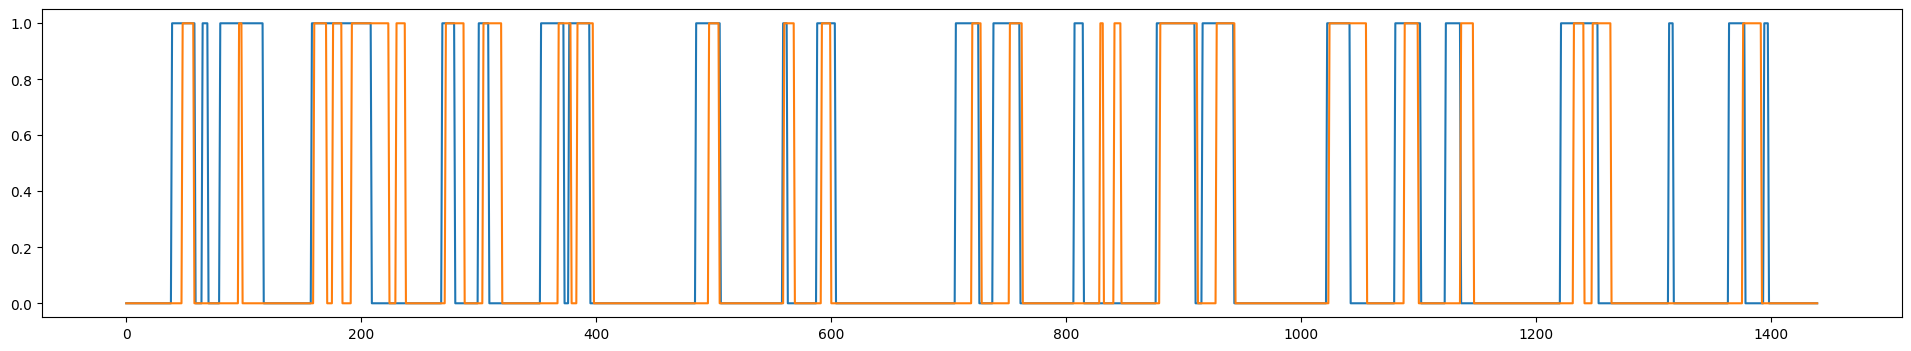

In [17]:
plt.figure(figsize=(24, 4))
plt.plot(y_test_flat)
plt.plot(y_preds_flat)
